In [37]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
#import needed csvs
df_plays = pd.read_csv('plays.csv')
df_player_play_motion = pd.read_csv('player_play_motion_labels.csv')

In [39]:
#label the different motion categories
motion_dict = {
    12:'Motion next to opposite side tackle',
    5:'Slot player cuts in front of the ball',
    2:'Motion to other side of line as a wideout',
    16:'Wideout cuts back towards the snap',
    1:'RB motions to other side of QB',
    22:'Slight motion next to Tackle',
    0:'Wideout motions closer to line',
    14:'Slot player moves towards the snap',
    19:'Wideout motions next to tackle',
    4:'Closer wideout motions to backfield', 
    17:'RB small motion forward',
    11:'Player slightly motions next to tackle', 
    3:'Wideout motions past ball then cuts back',
    8:'RB goes forward then returns',
    10:'RB motion in backfield',
    13:'Wideout motions further outside',
    6:'Backfield motions to closer wideout (same side)', 
    7:'Backfield motions to closer wideout (opposite side)',
    15:'Wideout motions to backfield',
    9:'Wideout motions to slot', 
    20:'Wideout moves back but returns to inital position',
    23:'Player behind tackle moves to wideout', 
    18:'Backfield motions to farther wideout (same side)',
    21:'Backfield motions to farther wideout (opposite side)',
    -1:'No Motion'
}

In [40]:
#find plays where there was a motion
df_motion_labels = df_player_play_motion[['gameId','playId','nflId','motion_label']]

df_plays_labeled = df_plays.merge(df_motion_labels,on=['gameId','playId'],how='left')
df_plays_labeled['motion_label'] = df_plays_labeled['motion_label'].fillna(-1)

df_plays_labeled['is_rush'] = np.where(df_plays_labeled['passResult'].isna(), 1, 0)

motion_dfs_dict = {label: group for label, group in df_plays_labeled.groupby('motion_label')}

In [41]:
#calculate average EPA for every motion category
motion_epa_data = []

for i in df_plays_labeled['motion_label'].unique():
    mean_value = motion_dfs_dict[i]['expectedPointsAdded'].mean()
    count_value = len(motion_dfs_dict[i]['expectedPointsAdded'])
    motion_epa_data.append([motion_dict[i], mean_value, count_value])

#export the data to a csv
df_motion_epa_data = pd.DataFrame(motion_epa_data, columns=["Motion Type", "Mean EPA", "Count"])
df_motion_epa_data.to_csv('epa_motion.csv')

print(df_motion_epa_data)

                                          Motion Type  Mean EPA  Count
0                                           No Motion -0.066150  12322
1            Wideout motions past ball then cuts back  0.201486    162
2                        Slight motion next to Tackle  0.128501    220
3   Backfield motions to closer wideout (opposite ... -0.004371    119
4                 Closer wideout motions to backfield -0.083418    170
5                      Wideout motions next to tackle -0.120343    196
6                             Wideout motions to slot -0.017665     89
7                 Motion next to opposite side tackle  0.125558    561
8                             RB small motion forward -0.019009    168
9               Slot player cuts in front of the ball  0.110514    465
10                     RB motions to other side of QB -0.082470    220
11    Backfield motions to closer wideout (same side)  0.074728    127
12                 Wideout cuts back towards the snap  0.335918    243
13    

In [42]:
#calculate run vs pass percentage for every motion category
data_run_pass_pct = []

#overall rush percentage
overall_rush_pct = df_plays_labeled['is_rush'].mean()
overall_count = len(df_plays_labeled['is_rush'])
data_run_pass_pct.append(['Overall', overall_rush_pct, overall_count])

#per motion rush percentage
for i in df_plays_labeled['motion_label'].unique():
    motion_rush_pct = motion_dfs_dict[i]['is_rush'].mean()
    motion_count = len(motion_dfs_dict[i]['is_rush'])
    data_run_pass_pct.append([motion_dict[i], motion_rush_pct, motion_count])

#export to csv
df_rush_data = pd.DataFrame(data_run_pass_pct, columns=["Motion Type", "Rush Percentage", "Count"])
df_rush_data.to_csv('motion_rush_data.csv', index=False)

#print results
print(df_rush_data)

                                          Motion Type  Rush Percentage  Count
0                                             Overall         0.389325  16806
1                                           No Motion         0.437916  12322
2            Wideout motions past ball then cuts back         0.259259    162
3                        Slight motion next to Tackle         0.240909    220
4   Backfield motions to closer wideout (opposite ...         0.260504    119
5                 Closer wideout motions to backfield         0.335294    170
6                      Wideout motions next to tackle         0.214286    196
7                             Wideout motions to slot         0.179775     89
8                 Motion next to opposite side tackle         0.295900    561
9                             RB small motion forward         0.351190    168
10              Slot player cuts in front of the ball         0.187097    465
11                     RB motions to other side of QB         0.

In [43]:
#now explore if the direction of the motion affects what direction a run goes in

In [44]:
#simplify dataframe
columns_for_run_dir = ['gameId', 'playId', 'nflId', 'teamAbbr','hadRushAttempt',
                        'overall_y_change','swapped_y_dir',
                        'swapped_side','position','y_flipped','init_rel_y_dis',
                       'end_rel_y_dis'
                       ]
df_run_loc = df_player_play_motion[columns_for_run_dir]

In [45]:
#moved towards ball
df_run_loc['moved_towards_snap'] = ((df_run_loc['overall_y_change'] > 100) & (df_run_loc['end_rel_y_dis'] > 0)).astype(int)

#moved away from ball
df_run_loc['moved_away_snap'] = (df_run_loc['overall_y_change'] < -100).astype(int)

C:\Users\etien\AppData\Local\Temp\ipykernel_46828\2294186511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run_loc['moved_towards_snap'] = ((df_run_loc['overall_y_change'] > 100) & (df_run_loc['end_rel_y_dis'] > 0)).astype(int)
C:\Users\etien\AppData\Local\Temp\ipykernel_46828\2294186511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run_loc['moved_away_snap'] = (df_run_loc['overall_y_change'] < -100).astype(int)


In [46]:
#flip y values back to their original values
df_run_loc.loc[df_run_loc['y_flipped'] == 1, ['overall_y_change', 'init_rel_y_dis', 'end_rel_y_dis','moved_towards_snap','moved_away_snap']] *= -1

In [47]:
df_plays_rush = df_plays_labeled[df_plays_labeled['passResult'].isna()]

In [48]:
#find how far the player moved towards the line 

df_run_loc.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,overall_y_change,swapped_y_dir,swapped_side,position,y_flipped,init_rel_y_dis,end_rel_y_dis,moved_towards_snap,moved_away_snap
0,2022090800,80,47857,BUF,0,-782,1,0,RB,1,-983,-201,-1,0
1,2022090800,101,53079,BUF,0,-322,1,1,FB,1,-2,320,0,0
2,2022090800,191,53079,BUF,0,59,0,0,FB,1,-554,-613,0,0
3,2022090800,236,52536,BUF,0,-500,0,0,WR,1,-1082,-582,-1,0
4,2022090800,299,43399,LA,0,481,0,1,TE,0,12,-469,0,0


In [49]:
#starting side
df_run_loc['starting_side'] = (df_run_loc['init_rel_y_dis'] > 0).astype(int)

C:\Users\etien\AppData\Local\Temp\ipykernel_46828\2615003364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_run_loc['starting_side'] = (df_run_loc['init_rel_y_dis'] > 0).astype(int)


In [50]:
df_rush_locations = df_plays_rush[['gameId','playId','rushLocationType']]

In [51]:
df_plays_rush_merge = df_run_loc.merge(df_rush_locations,on=['gameId','playId'],how='inner')

In [52]:
#filter out unknown rush areas
df_plays_only_rush = df_plays_rush_merge[df_plays_rush_merge['rushLocationType'] != 'UNKNOWN']

In [53]:
df_plays_only_rush.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,overall_y_change,swapped_y_dir,swapped_side,position,y_flipped,init_rel_y_dis,end_rel_y_dis,moved_towards_snap,moved_away_snap,starting_side,rushLocationType
0,2022090800,101,53079,BUF,0,-322,1,1,FB,1,-2,320,0,0,0,INSIDE_RIGHT
1,2022090800,191,53079,BUF,0,59,0,0,FB,1,-554,-613,0,0,0,OUTSIDE_RIGHT
2,2022090800,299,43399,LA,0,481,0,1,TE,0,12,-469,0,0,1,INSIDE_RIGHT
3,2022090800,299,43399,LA,0,481,0,1,TE,0,12,-469,0,0,1,INSIDE_RIGHT
4,2022090800,299,53678,LA,0,492,0,0,WR,0,1021,529,1,0,1,INSIDE_RIGHT


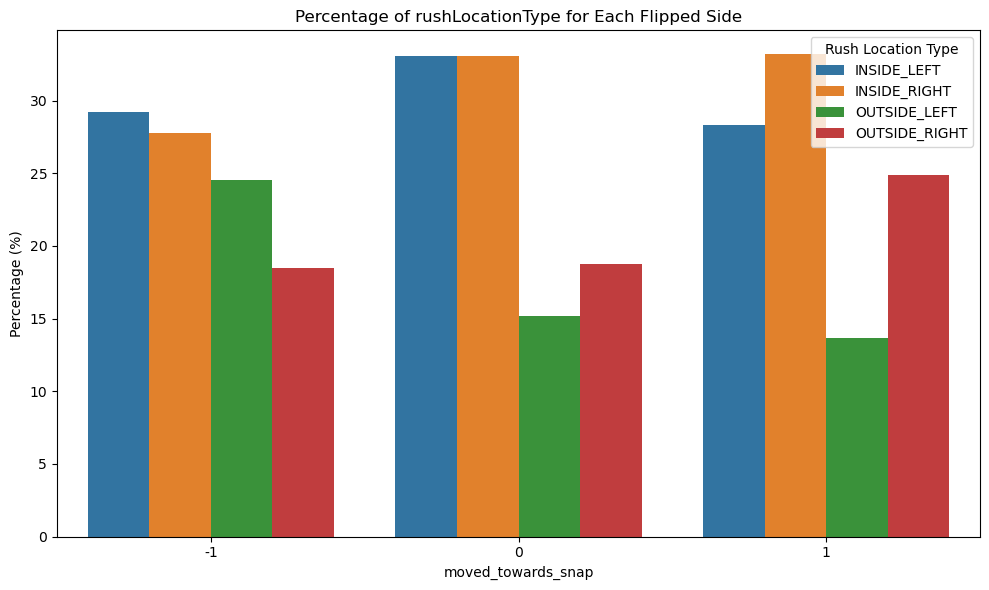

In [54]:
percentage_df = df_plays_only_rush.groupby(['moved_towards_snap', 'rushLocationType']).size().reset_index(name='count')
percentage_df['percentage'] = percentage_df.groupby('moved_towards_snap')['count'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot for visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=percentage_df, x='moved_towards_snap', y='percentage', hue='rushLocationType')
plt.title('Percentage of rushLocationType for Each Flipped Side')
plt.xlabel('moved_towards_snap')
plt.ylabel('Percentage (%)')
plt.legend(title='Rush Location Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

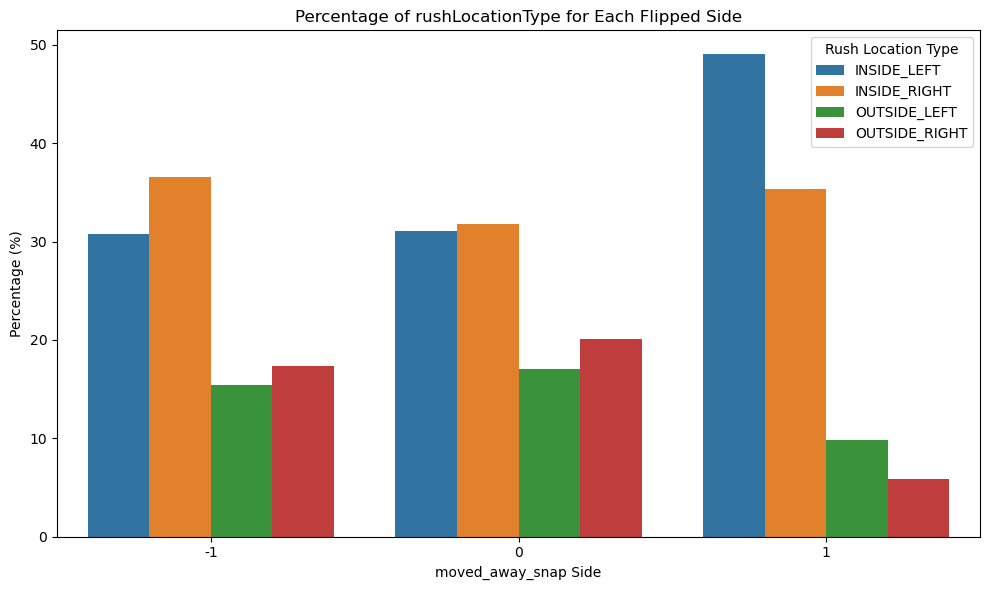

In [78]:
percentage_df = df_plays_rush_merge.groupby(['moved_away_snap', 'rushLocationType']).size().reset_index(name='count')
percentage_df['percentage'] = percentage_df.groupby('moved_away_snap')['count'].transform(lambda x: x / x.sum() * 100)

# Create a bar plot for visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=percentage_df, x='moved_away_snap', y='percentage', hue='rushLocationType')
plt.title('Percentage of rushLocationType for Each Flipped Side')
plt.xlabel('moved_away_snap Side')
plt.ylabel('Percentage (%)')
plt.legend(title='Rush Location Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [80]:
#find run percentage as well later

In [98]:
#Check for each category
df_labels_simp = df_plays_labeled[['gameId','playId','nflId','motion_label']]

In [104]:
#also note: players who went in motion the most
df_labels_simp['nflId'].value_counts()

nflId
47791.0    65
40011.0    61
45268.0    55
53541.0    45
46226.0    44
           ..
33130.0     1
42344.0     1
54563.0     1
41292.0     1
53517.0     1
Name: count, Length: 417, dtype: int64

In [114]:
#DO LEFT TO GET PERCENTAGES LATER
df_motion_rush_dir = df_labels_simp.merge(df_rush_locations,on=['gameId','playId'],how='inner')

In [120]:
df_motion_rush_dir = df_motion_rush_dir[df_motion_rush_dir['rushLocationType'] != 'UNKNOWN']

In [136]:
#need to separate motions that went from left to right side to better analyze
df_flipped = df_player_play_motion[['gameId','playId','y_flipped']]

In [140]:
df_motion_rush_dir = df_motion_rush_dir.merge(df_flipped,on=['gameId','playId'],how='inner')

In [128]:
#calculate average EPA for every motion category
rush_dir_per_cat = []

for i in df_motion_rush_dir['motion_label'].unique():
    filtered_df = df_motion_rush_dir[df_motion_rush_dir['motion_label'] == i]
    total_length = len(filtered_df)
    out_left_count = len(filtered_df[filtered_df['rushLocationType'] == 'OUTSIDE_LEFT']) / total_length
    in_left_count = len(filtered_df[filtered_df['rushLocationType'] == 'INSIDE_LEFT']) / total_length
    in_right_count = len(filtered_df[filtered_df['rushLocationType'] == 'INSIDE_RIGHT']) / total_length
    out_right_count = len(filtered_df[filtered_df['rushLocationType'] == 'OUTSIDE_RIGHT']) / total_length
    
    rush_dir_per_cat.append([i, out_left_count, in_left_count, in_right_count, out_right_count])

df_rush_dir_per_cat = pd.DataFrame(rush_dir_per_cat, columns=["Motion Type", "Out Left", "In Left", "In Right", "Out Right"])


print(df_rush_dir_per_cat)

    Motion Type  Out Left   In Left  In Right  Out Right
0          -1.0  0.195374  0.286370  0.295737   0.222520
1          22.0  0.242857  0.285714  0.171429   0.300000
2          12.0  0.144628  0.280992  0.376033   0.198347
3           3.0  0.326087  0.173913  0.260870   0.239130
4           7.0  0.055556  0.388889  0.444444   0.111111
5          16.0  0.237500  0.275000  0.281250   0.206250
6          10.0  0.090909  0.509091  0.327273   0.072727
7           9.0  0.161290  0.096774  0.645161   0.096774
8          19.0  0.153846  0.346154  0.326923   0.173077
9           2.0  0.133333  0.333333  0.300000   0.233333
10          8.0  0.293333  0.173333  0.306667   0.226667
11          5.0  0.177570  0.308411  0.355140   0.158879
12         20.0  0.040000  0.120000  0.800000   0.040000
13          1.0  0.187500  0.400000  0.312500   0.100000
14          4.0  0.154930  0.352113  0.323944   0.169014
15         17.0  0.212121  0.378788  0.212121   0.196970
16          6.0  0.076923  0.57

In [134]:
#were teams that went in that direction also more successful by EPA? This is the last rabbit hole to go down, need to put a close on this